In [1]:
import sys
sys.path.append("../")
sys.path.append("../../../assets")

# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import bayesflow as beef
import pandas as pd

from experiments import NonStationaryDDMExperiment
from models import MixtureRandomWalkDDM

/Users/lukas/opt/miniconda3/envs/beef/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# gpu setting and checking
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Constants

In [18]:
TRAIN_NETWORKS = False

NUM_OBS = 768
NUM_SAMPLES = 4000

MICRO_PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time']
MICRO_PARAM_NAMES  = [r'v', r'a', r'\tau']
MACRO_PARAM_LABELS = ['Transition std. deviation', 'Switch Probability']
MACRO_PARAM_NAMES  = [r'\sigma', r'q']
COMPARISON_COLOR = '#133a76'

FONT_SIZE_1 = 22
FONT_SIZE_2 = 20
FONT_SIZE_3 = 18

In [3]:
model = MixtureRandomWalkDDM()
experiment = NonStationaryDDMExperiment(model, checkpoint_path="../checkpoints/mixture_random_walk_ddm")

INFO:root:Performing 2 pilot runs with the mixture_random_walk_ddm model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 800)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.
INFO:root:Loaded loss history from ../checkpoints/mixture_random_walk_ddm/history_75.pkl.
INFO:root:Networks loaded from ../checkpoints/mixture_random_walk_ddm/ckpt-75
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Training

In [4]:
%%time
if TRAIN_NETWORKS:
    history = experiment.run(
        epochs=75, 
        iterations_per_epoch=1000, 
        batch_size=16
    )
else:
    history = experiment.trainer.loss_history.get_plottable()

CPU times: user 56 ms, sys: 3.27 ms, total: 59.3 ms
Wall time: 60.2 ms


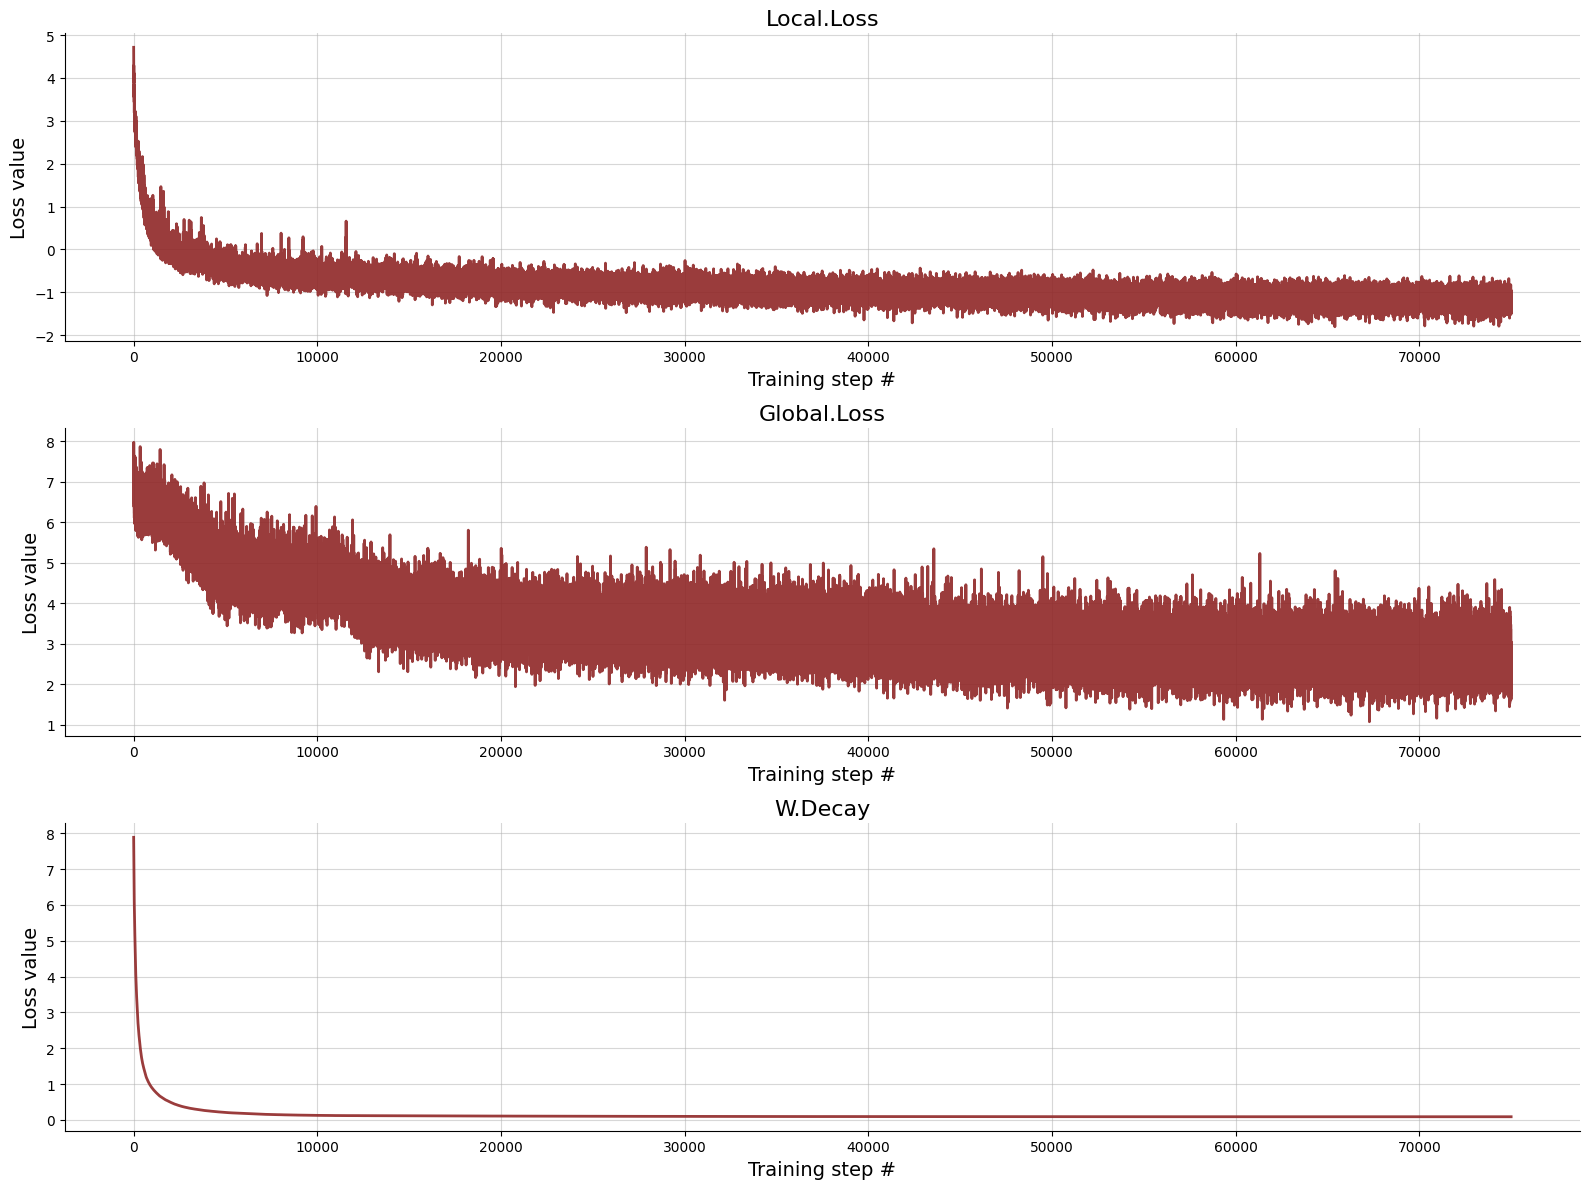

In [5]:
f = beef.diagnostics.plot_losses(history)

# Evaluation

## Calibration Error

## Parameter Recovery

In [21]:
val_data = model.configure(model.generate(1))
true_local_params = val_data['local_parameters'] * model.local_prior_stds + model.local_prior_means
true_hyper_params = val_data['hyper_parameters'] * model.hyper_prior_std + model.hyper_prior_mean

In [22]:
with tf.device('/cpu:0'):
    samples = experiment.amortizer.sample(val_data, NUM_SAMPLES)

### Local Parameters

In [23]:
local_post_samples = samples['local_samples'] * model.local_prior_stds + model.local_prior_means
local_post_mean = np.mean(local_post_samples, axis=1)
local_post_quantiles = np.quantile(local_post_samples, [0.025, 0.975], axis=1)

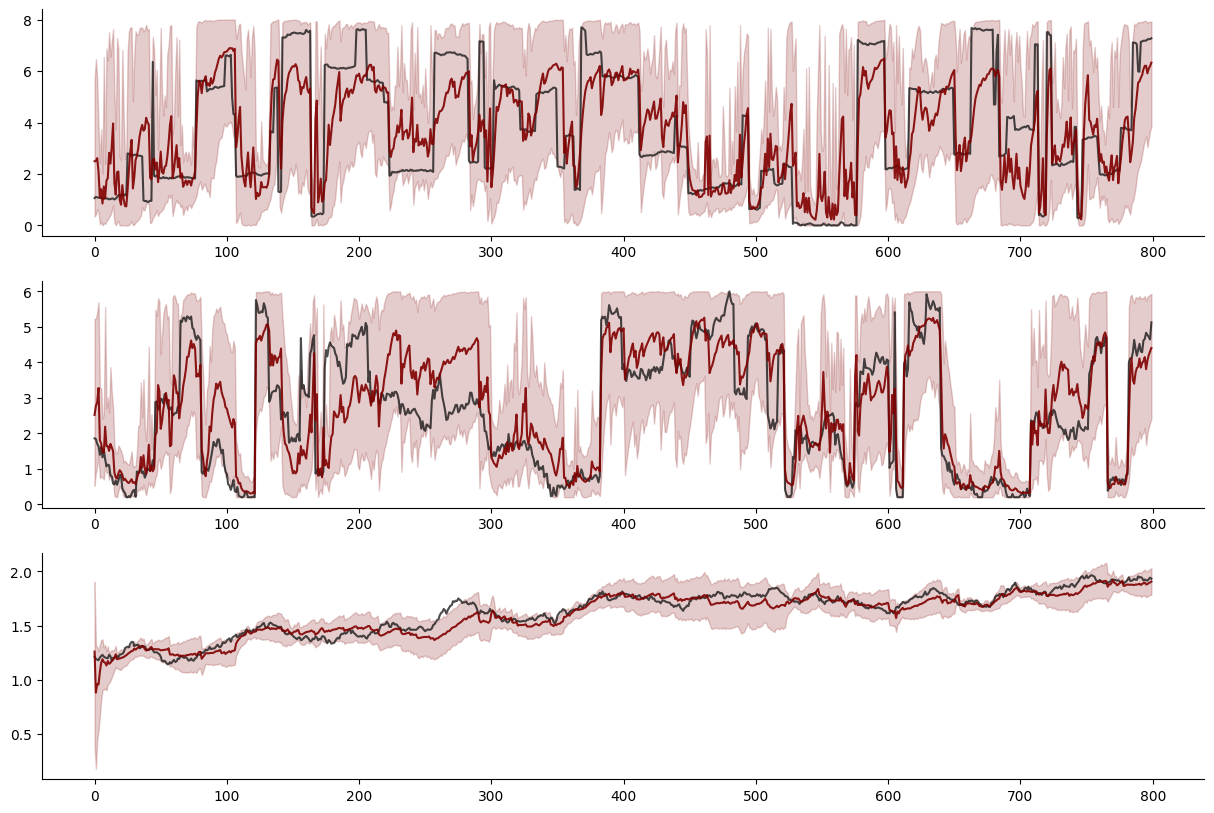

In [24]:
fig, axarr = plt.subplots(3, 1, figsize=(15, 10))
for i, ax in enumerate(axarr.flat):
    ax.plot(range(800), true_local_params[0, :, i] , color='black', alpha=0.7)
    ax.fill_between(range(800), local_post_quantiles[0, :, i], local_post_quantiles[1, :, i], color='maroon', alpha=0.2)
    ax.plot(range(800), local_post_mean[:, i], color='maroon', alpha=0.9)
sns.despine()

### Hyper Parameters

In [25]:
hyper_post_samples = samples['global_samples'] * model.hyper_prior_std + model.hyper_prior_mean
hyper_prior_draws = model.prior(NUM_SAMPLES)['hyper_parameters']

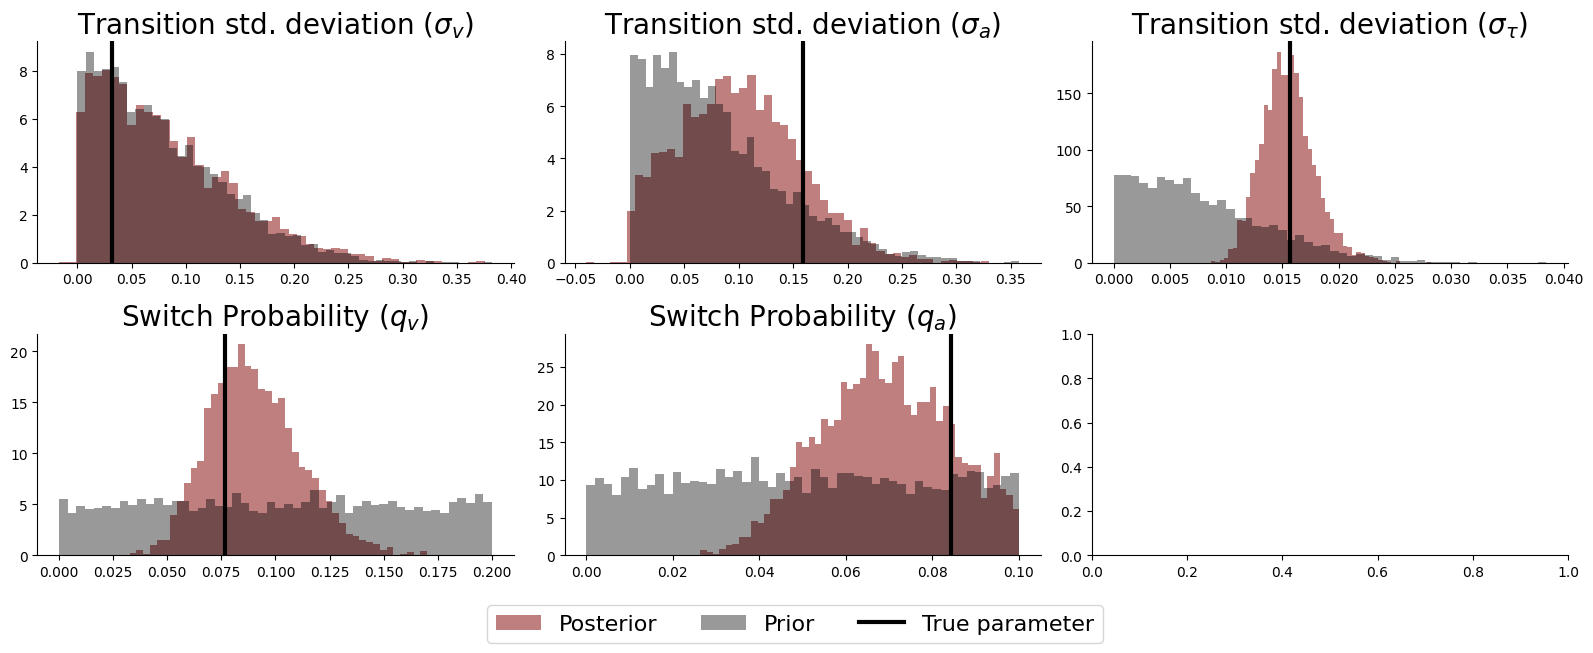

In [26]:
fig, axarr = plt.subplots(2, 3, figsize=(16, 6))
for i, ax in enumerate(axarr.flat):
    if i == 5:
        break
    ax.hist(hyper_post_samples[:, i], density=True, bins=50,
                 color='maroon', alpha=0.5, label='Posterior')
    ax.hist(hyper_prior_draws[:, i], density=True, bins=50,
                 color='black', alpha=0.4, label='Prior')
    ax.axvline(true_hyper_params[0, i], color='black',
               label='True parameter', lw=3)
    
    if i < 3:
        ax.set_title(f'{MACRO_PARAM_LABELS[0]} (${MACRO_PARAM_NAMES[0]}_{MICRO_PARAM_NAMES[i]}$)', fontsize=20)
    else:
        ax.set_title(f'{MACRO_PARAM_LABELS[1]} (${MACRO_PARAM_NAMES[1]}_{MICRO_PARAM_NAMES[i-3]}$)', fontsize=20)

    if i == 0:
        fig.legend(fontsize=16, loc='center',
                 bbox_to_anchor=(0.5, -0.05), ncol=4)

fig.tight_layout()
sns.despine()

# Parameter Estimation

In [30]:
data = pd.read_csv('../data/data_color_discrimination.csv')
data['rt'] = np.where(data['correct'] == 0, -data['rt'], data['rt'])

In [31]:
NUM_SUBJECTS = len(np.unique(data['id']))
emp_data = np.zeros((NUM_SUBJECTS, NUM_OBS, 1), dtype=np.float32)
for i in range(NUM_SUBJECTS):
    tmp = data[data['id'] == i+1]
    emp_data[i] = tmp['rt'].to_numpy()[:, np.newaxis]

emp_data.shape

(14, 768, 1)

In [32]:
%%time
local_post_samples = np.zeros((NUM_SUBJECTS, NUM_OBS, NUM_SAMPLES, 3))
hyper_post_samples = np.zeros((NUM_SUBJECTS, NUM_SAMPLES, 5))
with tf.device('/cpu:0'):
    for i in range(NUM_SUBJECTS):
        tmp_data = {'summary_conditions': emp_data[i:i+1]}
        samples = experiment.amortizer.sample(tmp_data, NUM_SAMPLES)
        local_post_samples[i] = samples['local_samples']
        hyper_post_samples[i] = samples['global_samples']

CPU times: user 55min 32s, sys: 18min 33s, total: 1h 14min 6s
Wall time: 29min 33s


In [33]:
local_post = local_post_samples * model.local_prior_stds + model.local_prior_means
hyper_post = hyper_post_samples * model.hyper_prior_std + model.hyper_prior_mean

In [57]:
np.save("../data/local_post_samples_mrw.npy", local_post)

In [53]:
# get person data
which = 3
person_data = data[data['id'] == which + 1]
condition = person_data['speed_condition'].to_numpy()
idx_speed = np.where(condition[:-1] != condition[1:])[0]
idx_speed = np.append(idx_speed, NUM_OBS)
idx_speed

array([ 47,  95, 143, 191, 239, 287, 335, 383, 431, 479, 527, 575, 623,
       671, 719, 768])

In [54]:
person_post_samples = local_post[which]
post_mean = np.mean(person_post_samples, axis=1)
post_std = np.std(person_post_samples, axis=1)

/var/folders/bv/vht4zx991wd5ygpm2yz12gd40000gn/T/ipykernel_82642/1134304507.py:33: UserWarning: The figure layout has changed to tight
  f.tight_layout()


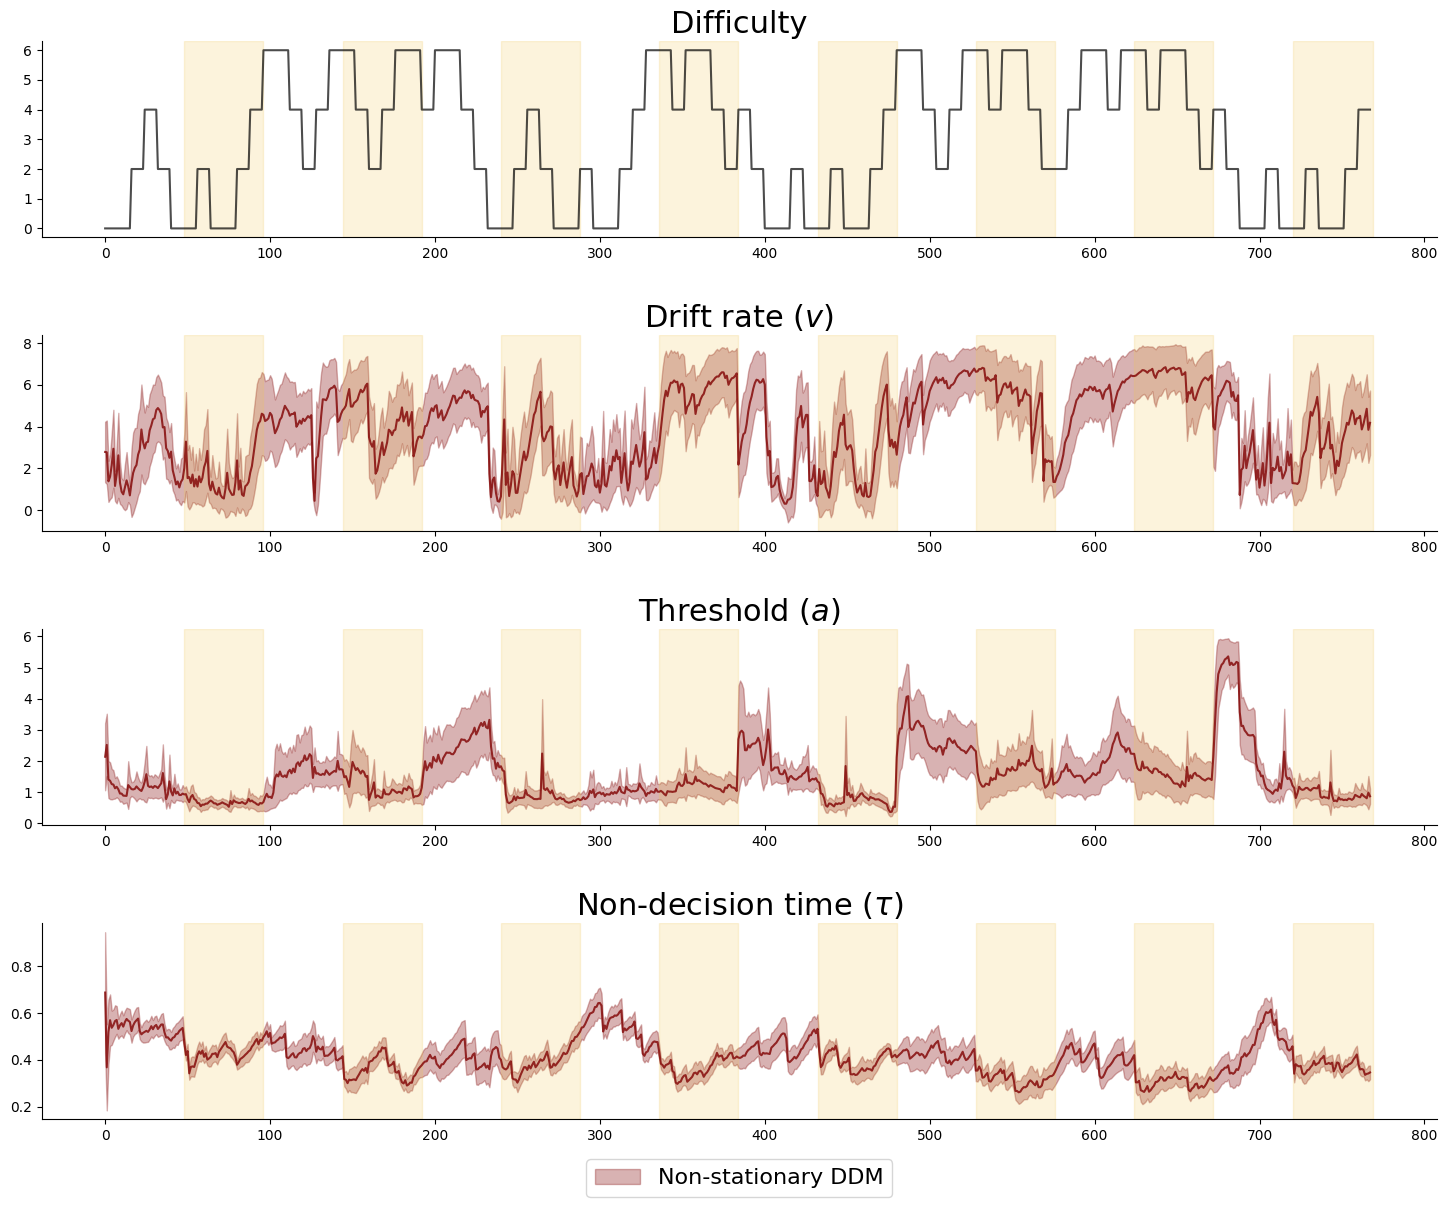

In [55]:
fig, axarr = plt.subplots(4, 1, figsize=(18, 14))
for i, ax in enumerate(axarr.flat):
    if i == 0:
        # ax.plot(range(N_OBS), person_data['difficulty'], color='black')
        ax.plot(range(NUM_OBS), (person_data['difficulty'] - 3) * -2, color='black', alpha=0.7)
        ax.set_title('Difficulty', fontsize=FONT_SIZE_1)
    else:
        # neural
        ax.fill_between(range(NUM_OBS), post_mean[:, i-1] - post_std[:, i-1],
                        post_mean[:, i-1] + post_std[:, i-1],
                        color='maroon', alpha=0.3, label="Non-stationary DDM")
        ax.plot(range(NUM_OBS), post_mean[:, i-1], color='maroon', alpha=0.8)
        ax.set_title(f'{MICRO_PARAM_LABELS[i-1]} (${MICRO_PARAM_NAMES[i-1]}$)', fontsize=FONT_SIZE_1)

        # stan
        # ax.fill_between(range(NUM_OBS), stan_post_means[:, i-1] - stan_post_stds[:, i-1],
        #                 stan_post_means[:, i-1] + stan_post_stds[:, i-1],
        #                 color=COMPARISON_COLOR, alpha=0.3, label="Stationary DDM")
        # ax.plot(range(N_OBS), stan_post_means[:, i-1], color=COMPARISON_COLOR, alpha=0.8)
    
    x = 0
    while x < idx_speed.shape[0]:
        ax.axvspan(idx_speed[x] + 1, idx_speed[x + 1] + 1, alpha=0.2, color='#f0c654')
        x = x + 2
    
# axarr[1].plot(range(N_OBS), (person_data['difficulty'] - 3) * -2, color='black', alpha=0.5)
    
    if i == 3:
        plt.subplots_adjust(hspace=0.5)
        plt.legend(fontsize=16, loc='center', 
                bbox_to_anchor=(0.5, -0.3), ncol=2)
sns.despine()
f.tight_layout()
# plt.savefig("../plots/param_dynamics.png", dpi=300, bbox_inches="tight")